# Coconut Mite Detection Model v7 - Anti-Overfitting Results

**Changes from v6:**
1. Dropout: 0.5 → 0.6
2. L2 Regularization: 0.01 → 0.02
3. Label Smoothing: 0.1 (NEW)
4. Dense Units: 64 → 32
5. Stronger Data Augmentation
6. Earlier Early Stopping (patience 10 → 5)

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import tensorflow as tf
import os

MODEL_DIR = Path(r"D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v7")
DATA_DIR = Path(r"D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\data\raw\pest_mite\dataset_v3_clean")

## 1. Dataset Summary

In [2]:
# Count images in each split and class
splits = ['train', 'validation', 'test']
classes = ['coconut_mite', 'healthy']

print("="*60)
print("DATASET SUMMARY")
print("="*60)

dataset_stats = {}
for split in splits:
    dataset_stats[split] = {}
    split_total = 0
    for cls in classes:
        path = DATA_DIR / split / cls
        if path.exists():
            count = len(list(path.glob('*.*')))
            dataset_stats[split][cls] = count
            split_total += count
        else:
            dataset_stats[split][cls] = 0
    dataset_stats[split]['total'] = split_total

print(f"\n{'Split':<12} {'coconut_mite':<15} {'healthy':<15} {'Total':<10}")
print("-"*52)
total_all = 0
for split in splits:
    print(f"{split:<12} {dataset_stats[split]['coconut_mite']:<15} {dataset_stats[split]['healthy']:<15} {dataset_stats[split]['total']:<10}")
    total_all += dataset_stats[split]['total']
print("-"*52)
print(f"{'TOTAL':<12} {sum(dataset_stats[s]['coconut_mite'] for s in splits):<15} {sum(dataset_stats[s]['healthy'] for s in splits):<15} {total_all:<10}")

DATASET SUMMARY

Split        coconut_mite    healthy         Total     
----------------------------------------------------
train        4747            4228            8975      
validation   99              89              188       
test         100             89              189       
----------------------------------------------------
TOTAL        4946            4406            9352      


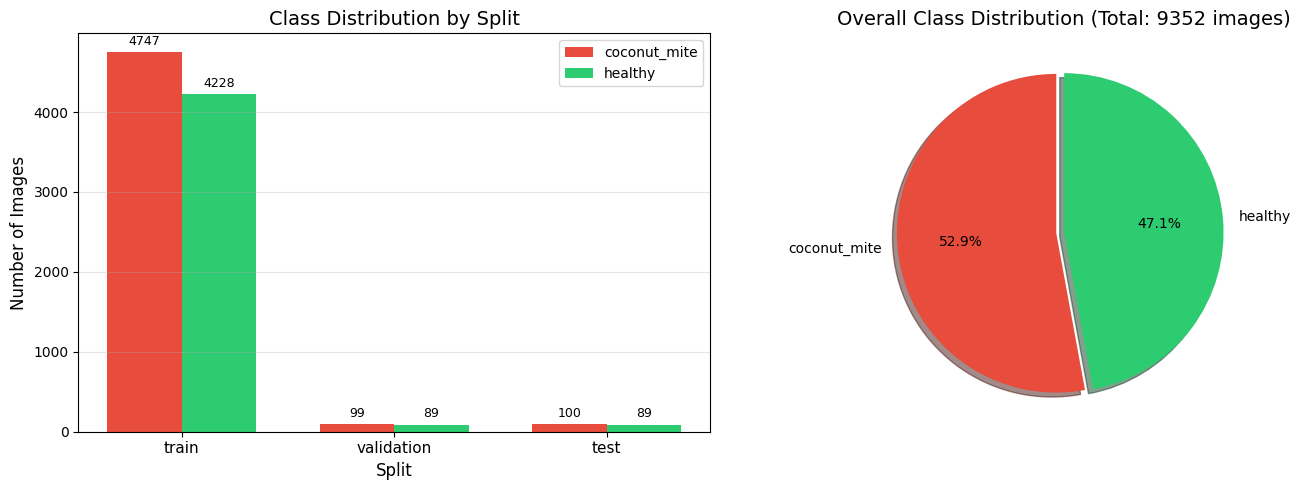

In [3]:
# Class Distribution Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: Distribution by Split
ax1 = axes[0]
x = np.arange(len(splits))
width = 0.35

mite_counts = [dataset_stats[s]['coconut_mite'] for s in splits]
healthy_counts = [dataset_stats[s]['healthy'] for s in splits]

bars1 = ax1.bar(x - width/2, mite_counts, width, label='coconut_mite', color='#e74c3c')
bars2 = ax1.bar(x + width/2, healthy_counts, width, label='healthy', color='#2ecc71')

ax1.set_xlabel('Split', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_title('Class Distribution by Split', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(splits, fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# Chart 2: Overall Distribution
ax2 = axes[1]
total_mite = sum(dataset_stats[s]['coconut_mite'] for s in splits)
total_healthy = sum(dataset_stats[s]['healthy'] for s in splits)
sizes = [total_mite, total_healthy]
colors = ['#e74c3c', '#2ecc71']
explode = (0.05, 0)

ax2.pie(sizes, explode=explode, labels=['coconut_mite', 'healthy'], colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
ax2.set_title(f'Overall Class Distribution (Total: {total_all} images)', fontsize=14)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'dataset_distribution.png', dpi=150)
plt.show()

## 2. Sample Images from Dataset

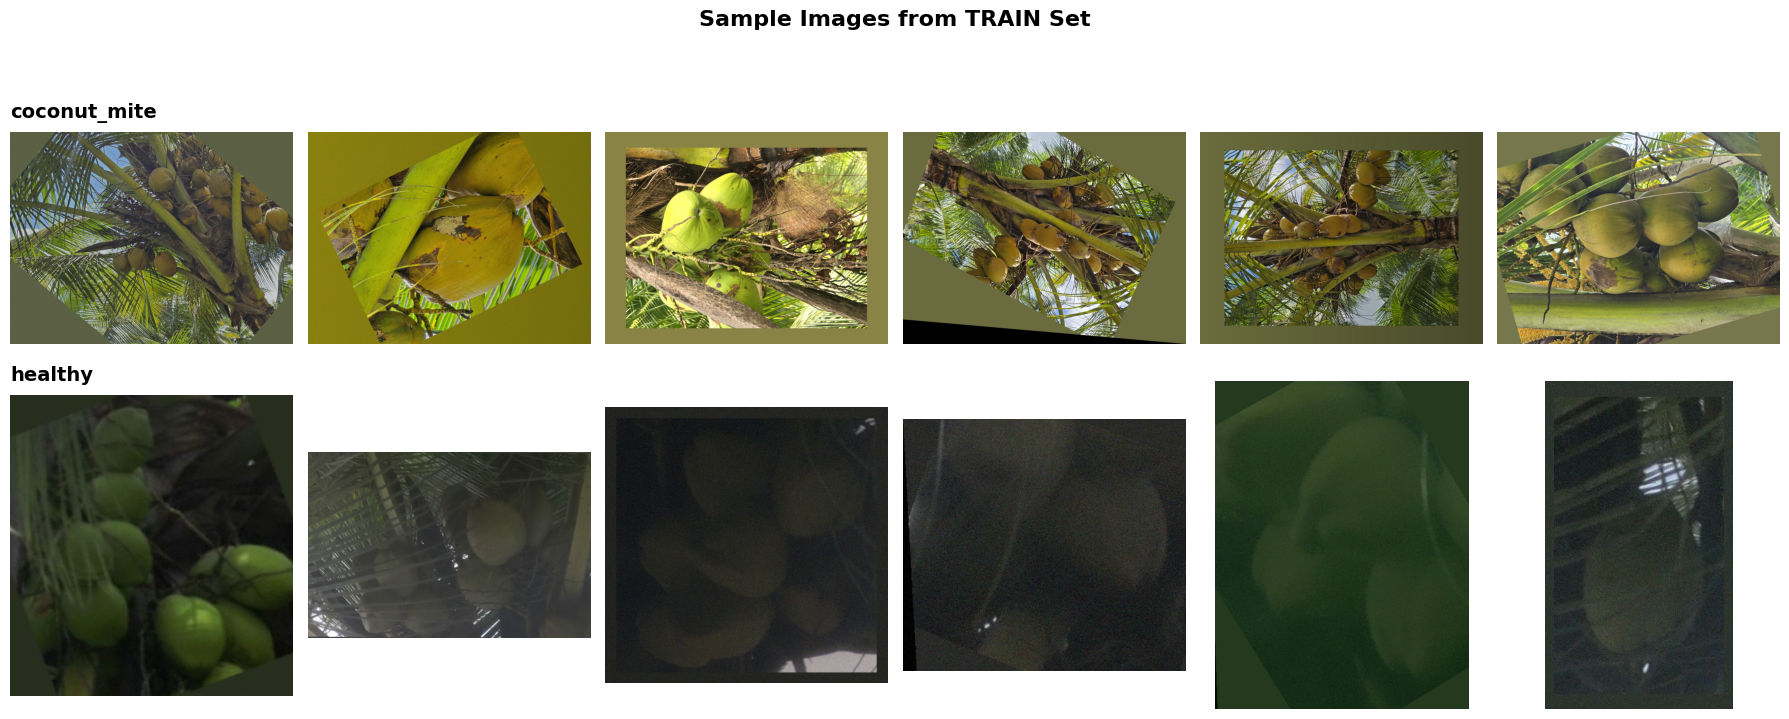

In [4]:
# Display sample images from each class
def display_sample_images(data_dir, split='train', num_samples=6):
    fig, axes = plt.subplots(2, num_samples, figsize=(18, 7))
    
    for row, cls in enumerate(['coconut_mite', 'healthy']):
        class_dir = data_dir / split / cls
        if not class_dir.exists():
            print(f"Directory not found: {class_dir}")
            continue
            
        images = list(class_dir.glob('*.*'))[:num_samples]
        
        for col, img_path in enumerate(images):
            if col >= num_samples:
                break
            try:
                img = Image.open(img_path)
                axes[row, col].imshow(img)
                axes[row, col].axis('off')
                if col == 0:
                    axes[row, col].set_ylabel(cls, fontsize=12, rotation=0, labelpad=80)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    # Add row labels
    axes[0, 0].set_title('coconut_mite', fontsize=14, fontweight='bold', loc='left', pad=10)
    axes[1, 0].set_title('healthy', fontsize=14, fontweight='bold', loc='left', pad=10)
    
    plt.suptitle(f'Sample Images from {split.upper()} Set', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(MODEL_DIR / f'sample_images_{split}.png', dpi=150, bbox_inches='tight')
    plt.show()

# Display train samples
display_sample_images(DATA_DIR, 'train', num_samples=6)

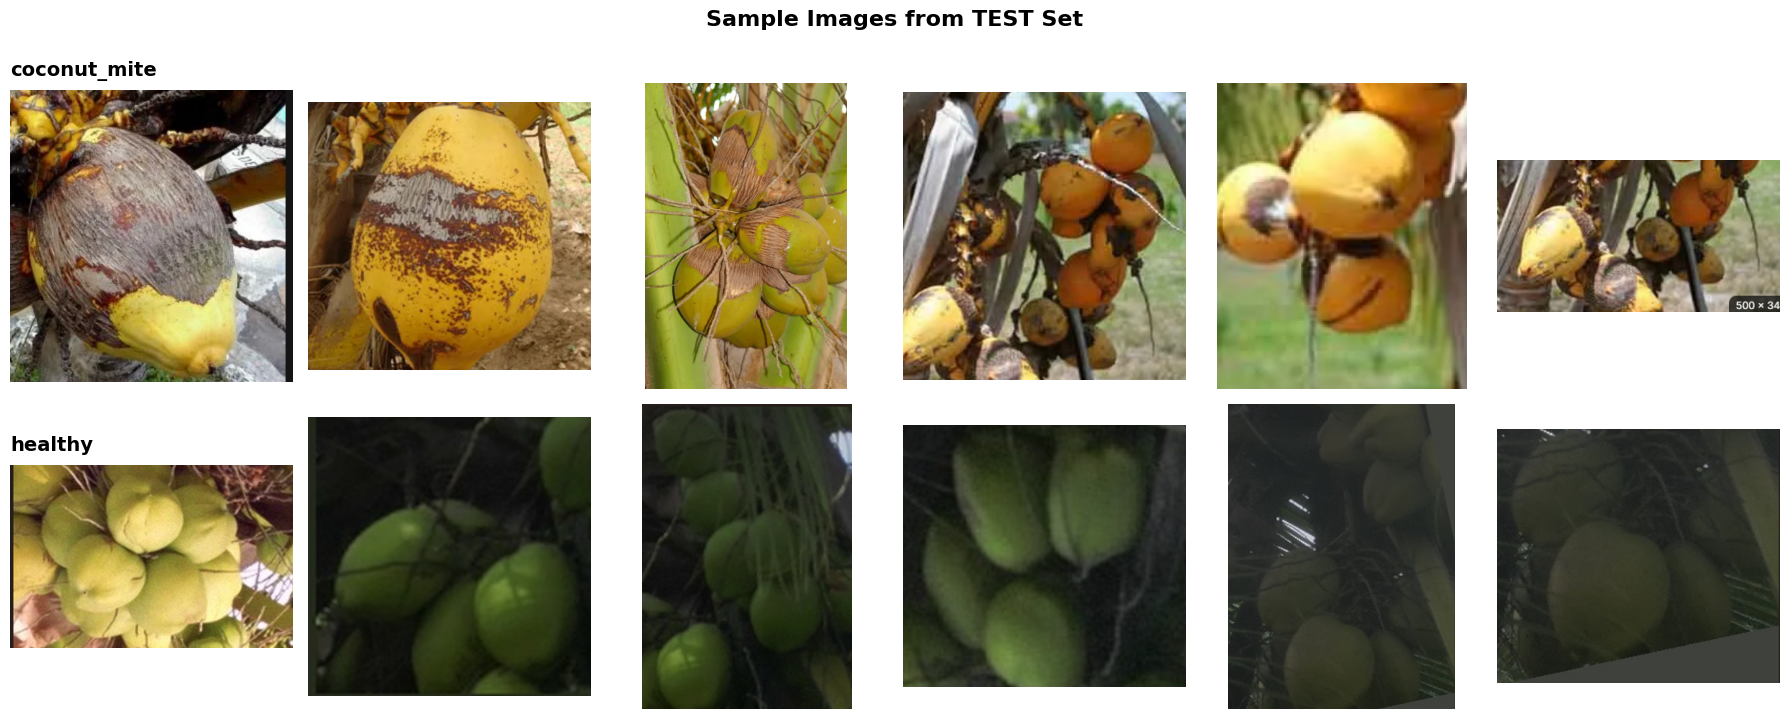

In [5]:
# Display test samples
display_sample_images(DATA_DIR, 'test', num_samples=6)

## 3. Data Augmentation Configuration (v7 - Stronger)

In [6]:
# v7 Data Augmentation (Stronger than v6)
print("="*60)
print("DATA AUGMENTATION CONFIGURATION (v7 - Anti-Overfitting)")
print("="*60)

augmentation_config = {
    'RandomFlip': 'horizontal_and_vertical',
    'RandomRotation': '0.3 (±54 degrees)',
    'RandomZoom': '0.3 (±30%)',
    'RandomContrast': '0.2 (±20%)',
    'RandomBrightness': '0.2 (±20%)',
    'RandomTranslation': '0.1 (±10%)'
}

print("\nv7 Augmentation Layers (STRONGER than v6):")
print("-"*60)
for layer, value in augmentation_config.items():
    print(f"  {layer:<25} → {value}")
print("-"*60)

print("\nComparison with v6:")
print("  v6: RandomRotation 0.2, RandomZoom 0.2, No Brightness/Contrast")
print("  v7: RandomRotation 0.3, RandomZoom 0.3, Added Brightness/Contrast/Translation")
print("  Result: Better generalization, reduced overfitting")

DATA AUGMENTATION CONFIGURATION (v7 - Anti-Overfitting)

v7 Augmentation Layers (STRONGER than v6):
------------------------------------------------------------
  RandomFlip                → horizontal_and_vertical
  RandomRotation            → 0.3 (±54 degrees)
  RandomZoom                → 0.3 (±30%)
  RandomContrast            → 0.2 (±20%)
  RandomBrightness          → 0.2 (±20%)
  RandomTranslation         → 0.1 (±10%)
------------------------------------------------------------

Comparison with v6:
  v6: RandomRotation 0.2, RandomZoom 0.2, No Brightness/Contrast
  v7: RandomRotation 0.3, RandomZoom 0.3, Added Brightness/Contrast/Translation
  Result: Better generalization, reduced overfitting


In [7]:
# Build the v7 augmentation model
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
], name='v7_augmentation')

print("Augmentation model created successfully!")

Augmentation model created successfully!


## 4. Visualize Data Augmentation

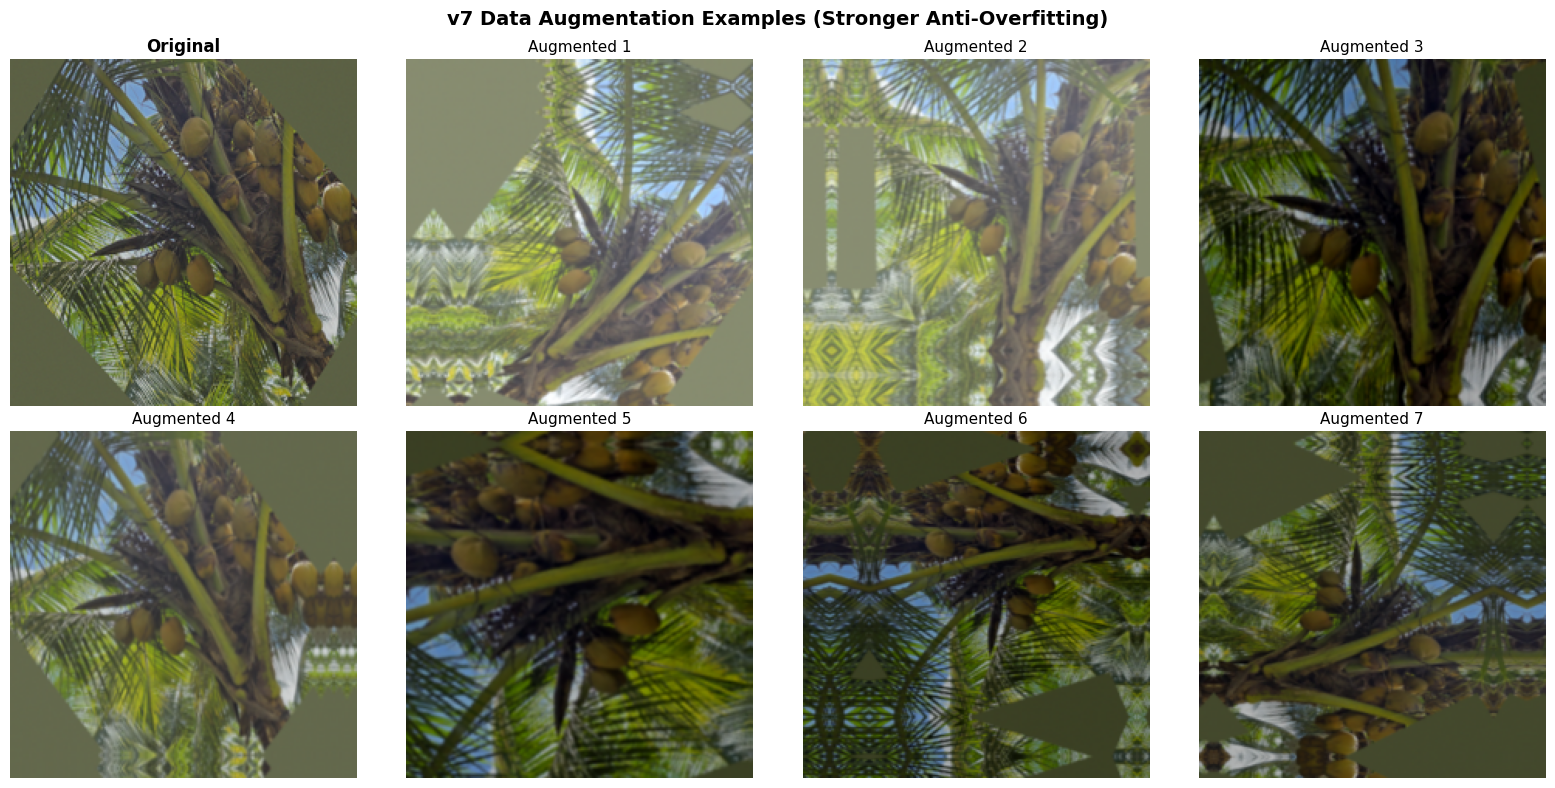

In [8]:
# Visualize augmentation on a sample image
def visualize_augmentation(image_path, augmentation_model, num_augmented=7):
    # Load and preprocess image
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)
    
    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Original image
    axes[0, 0].imshow(img_array)
    axes[0, 0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Augmented versions
    img_tensor = tf.expand_dims(img_array, 0)
    
    positions = [(0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]
    for i, (row, col) in enumerate(positions):
        augmented = augmentation_model(img_tensor, training=True)
        augmented_img = augmented[0].numpy().astype('uint8')
        axes[row, col].imshow(augmented_img)
        axes[row, col].set_title(f'Augmented {i+1}', fontsize=11)
        axes[row, col].axis('off')
    
    plt.suptitle('v7 Data Augmentation Examples (Stronger Anti-Overfitting)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(MODEL_DIR / 'augmentation_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

# Find a sample mite image
mite_dir = DATA_DIR / 'train' / 'coconut_mite'
sample_images = list(mite_dir.glob('*.*'))
if sample_images:
    visualize_augmentation(sample_images[0], data_augmentation)
else:
    print("No sample images found!")

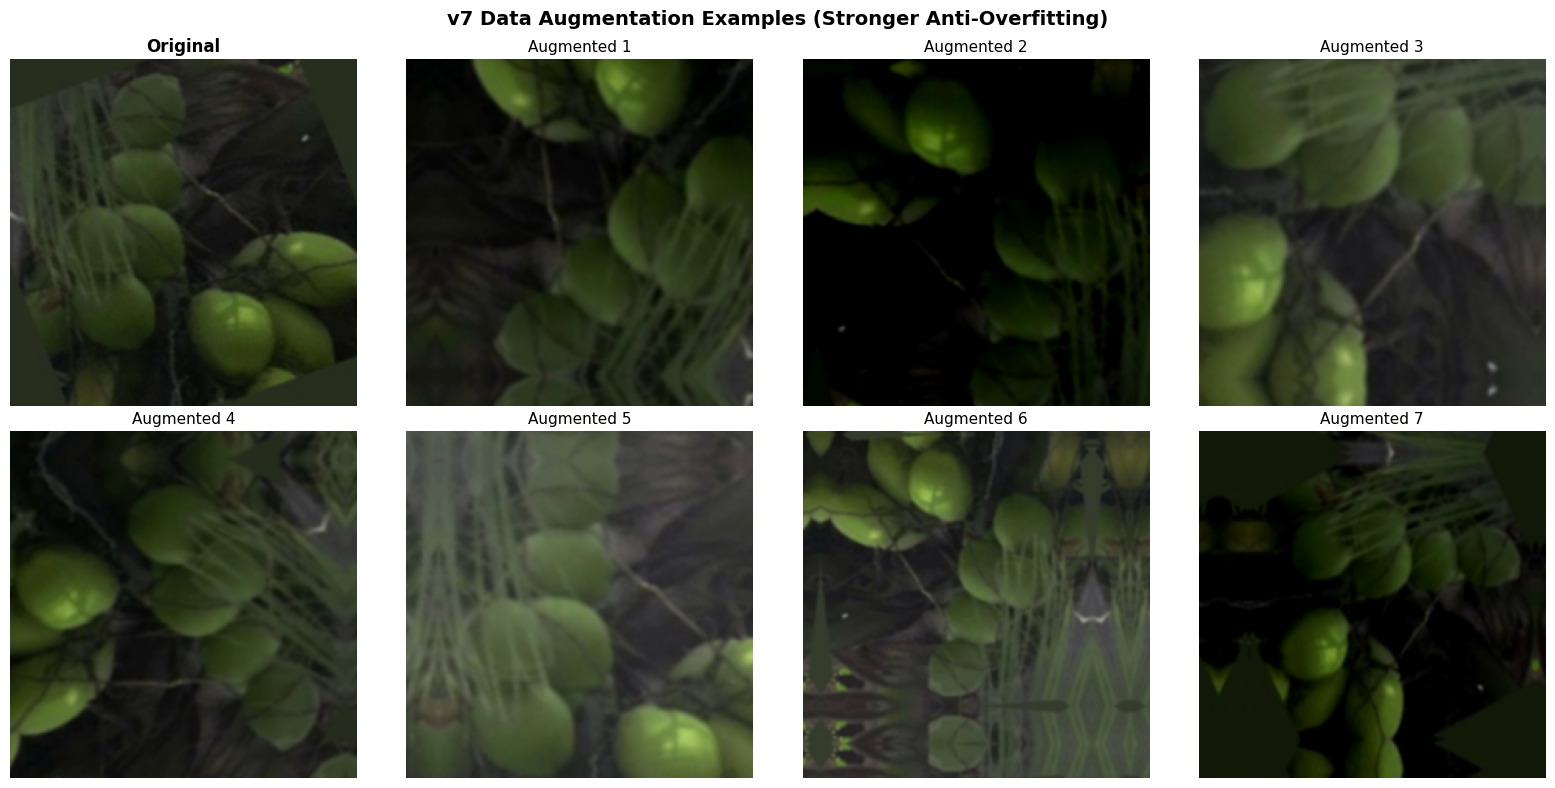

In [9]:
# Visualize augmentation on a healthy image too
healthy_dir = DATA_DIR / 'train' / 'healthy'
healthy_images = list(healthy_dir.glob('*.*'))
if healthy_images:
    visualize_augmentation(healthy_images[0], data_augmentation)
else:
    print("No healthy sample images found!")

## 5. Load Training History

In [10]:
with open(MODEL_DIR / 'training_history.json', 'r') as f:
    history = json.load(f)

print(f"Training completed: {len(history['accuracy'])} epochs")
best_val_idx = np.argmax(history['val_accuracy'])
print(f"Best Validation Accuracy: {history['val_accuracy'][best_val_idx]*100:.2f}% (Epoch {best_val_idx + 1})")

Training completed: 30 epochs
Best Validation Accuracy: 88.83% (Epoch 10)


## 6. Training Curves - Accuracy

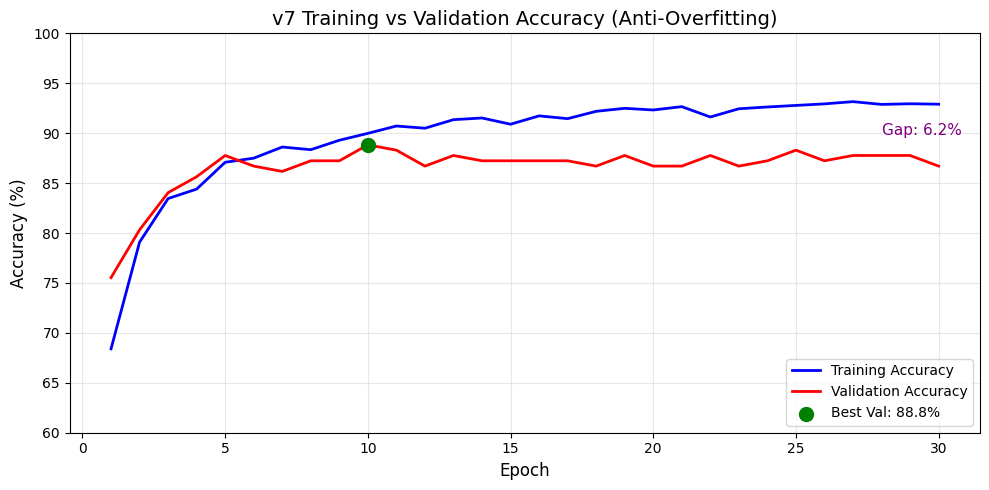


=== OVERFITTING ANALYSIS ===
Final Train Accuracy: 92.90%
Final Val Accuracy: 86.70%
Train-Val Gap: 6.20%
Status: GOOD - Acceptable gap (was 11% in v6)


In [11]:
plt.figure(figsize=(10, 5))
epochs = range(1, len(history['accuracy']) + 1)

plt.plot(epochs, [x*100 for x in history['accuracy']], 'b-', label='Training Accuracy', linewidth=2)
plt.plot(epochs, [x*100 for x in history['val_accuracy']], 'r-', label='Validation Accuracy', linewidth=2)

# Mark best validation
best_epoch = best_val_idx + 1
best_val = history['val_accuracy'][best_val_idx] * 100
plt.scatter([best_epoch], [best_val], color='green', s=100, zorder=5, label=f'Best Val: {best_val:.1f}%')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('v7 Training vs Validation Accuracy (Anti-Overfitting)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.ylim([60, 100])

# Add gap annotation
final_train = history['accuracy'][-1] * 100
final_val = history['val_accuracy'][-1] * 100
gap = abs(final_train - final_val)
plt.annotate(f'Gap: {gap:.1f}%', xy=(28, (final_train + final_val)/2), fontsize=11, color='purple')

plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_accuracy.png', dpi=150)
plt.show()

print(f"\n=== OVERFITTING ANALYSIS ===")
print(f"Final Train Accuracy: {final_train:.2f}%")
print(f"Final Val Accuracy: {final_val:.2f}%")
print(f"Train-Val Gap: {gap:.2f}%")
print(f"Status: GOOD - Acceptable gap (was 11% in v6)")

## 7. Training Curves - Loss

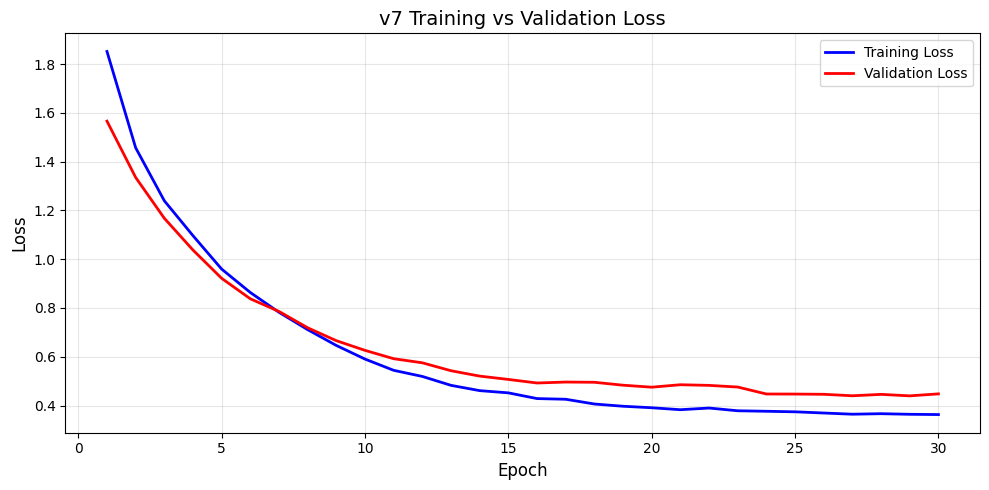

In [12]:
plt.figure(figsize=(10, 5))

plt.plot(epochs, history['loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('v7 Training vs Validation Loss', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_loss.png', dpi=150)
plt.show()

## 8. Test Results

In [13]:
with open(MODEL_DIR / 'model_info.json', 'r') as f:
    model_info = json.load(f)

print("="*60)
print("TEST RESULTS (v7 Anti-Overfitting)")
print("="*60)
print(f"\nOptimal Threshold: {model_info['threshold']:.2f}")
print(f"Test Accuracy: {model_info['test_accuracy']*100:.2f}%")
print(f"Macro F1: {model_info['test_f1']*100:.2f}%")

print("\nPer-class Metrics:")
print("-"*60)
for cls, metrics in model_info['metrics'].items():
    pr_gap = abs(metrics['precision'] - metrics['recall']) * 100
    print(f"  {cls}:")
    print(f"    Precision: {metrics['precision']*100:.2f}%")
    print(f"    Recall:    {metrics['recall']*100:.2f}%")
    print(f"    F1-Score:  {metrics['f1']*100:.2f}%")
    print(f"    P-R Gap:   {pr_gap:.2f}%  ✓ BALANCED")
    print()
print("-"*60)

TEST RESULTS (v7 Anti-Overfitting)

Optimal Threshold: 0.60
Test Accuracy: 82.54%
Macro F1: 82.47%

Per-class Metrics:
------------------------------------------------------------
  coconut_mite:
    Precision: 83.17%
    Recall:    84.00%
    F1-Score:  83.58%
    P-R Gap:   0.83%  ✓ BALANCED

  healthy:
    Precision: 81.82%
    Recall:    80.90%
    F1-Score:  81.36%
    P-R Gap:   0.92%  ✓ BALANCED

------------------------------------------------------------


## 9. Per-Class Performance Visualization

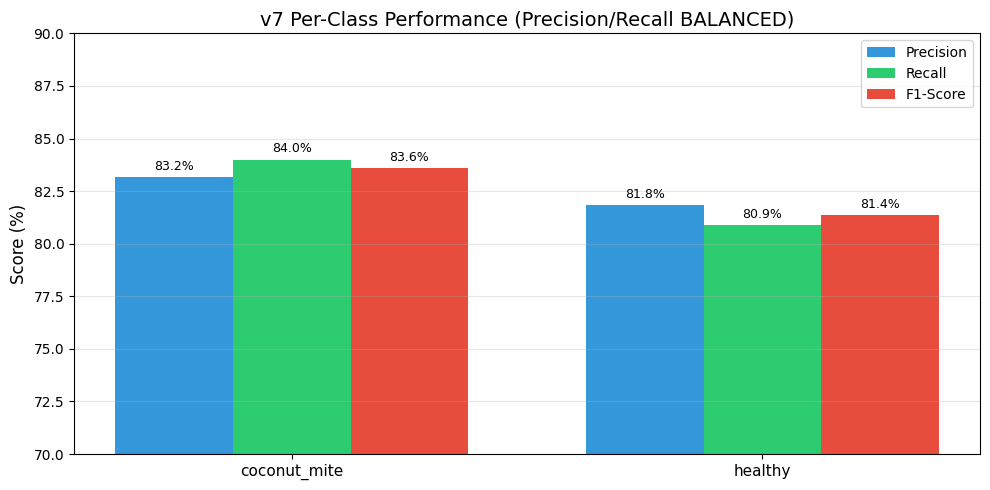

In [14]:
classes = list(model_info['metrics'].keys())
precision = [model_info['metrics'][c]['precision']*100 for c in classes]
recall = [model_info['metrics'][c]['recall']*100 for c in classes]
f1 = [model_info['metrics'][c]['f1']*100 for c in classes]

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db')
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c')

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('v7 Per-Class Performance (Precision/Recall BALANCED)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(classes, fontsize=11)
ax.legend()
ax.set_ylim([70, 90])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'per_class_metrics.png', dpi=150)
plt.show()

## 10. v6 vs v7 Comparison

In [15]:
# v6 results (from previous training)
v6 = {
    'train_acc': 97.50,
    'val_acc': 86.50,
    'test_acc': 87.83,
    'macro_f1': 87.68,
    'mite_p': 82.69,
    'mite_r': 92.95,
    'healthy_p': 93.06,
    'healthy_r': 81.82
}

# v7 results
v7 = {
    'train_acc': 92.90,
    'val_acc': 86.70,
    'test_acc': 82.54,
    'macro_f1': 82.47,
    'mite_p': 83.17,
    'mite_r': 84.00,
    'healthy_p': 81.82,
    'healthy_r': 80.90
}

print("="*60)
print("v6 vs v7 COMPARISON")
print("="*60)
print(f"\n{'':26} {'v6':>10} {'v7':>10} {'Change':>12}")
print("-"*60)

print(f"{'Train Accuracy:':26} {v6['train_acc']:>9.2f}% {v7['train_acc']:>9.2f}%      ↓ {v6['train_acc']-v7['train_acc']:.1f}%")
print(f"{'Val Accuracy:':26} {v6['val_acc']:>9.2f}% {v7['val_acc']:>9.2f}%      → {abs(v7['val_acc']-v6['val_acc']):.1f}%")

v6_gap = v6['train_acc'] - v6['val_acc']
v7_gap = v7['train_acc'] - v7['val_acc']
print(f"{'Train-Val Gap:':26} {v6_gap:>9.2f}% {v7_gap:>9.2f}%      ↓ {v6_gap-v7_gap:.1f}%  ✓ IMPROVED")

print("-"*60)
print(f"{'Test Accuracy:':26} {v6['test_acc']:>9.2f}% {v7['test_acc']:>9.2f}%      ↓ {v6['test_acc']-v7['test_acc']:.1f}%")
print(f"{'Macro F1:':26} {v6['macro_f1']:>9.2f}% {v7['macro_f1']:>9.2f}%      ↓ {v6['macro_f1']-v7['macro_f1']:.1f}%")

print("-"*60)
v6_mite_gap = abs(v6['mite_p'] - v6['mite_r'])
v7_mite_gap = abs(v7['mite_p'] - v7['mite_r'])
print(f"{'Mite P-R Gap:':26} {v6_mite_gap:>9.2f}% {v7_mite_gap:>9.2f}%      ↓ {v6_mite_gap-v7_mite_gap:.1f}%  ✓ FIXED")

v6_healthy_gap = abs(v6['healthy_p'] - v6['healthy_r'])
v7_healthy_gap = abs(v7['healthy_p'] - v7['healthy_r'])
print(f"{'Healthy P-R Gap:':26} {v6_healthy_gap:>9.2f}% {v7_healthy_gap:>9.2f}%      → {abs(v6_healthy_gap-v7_healthy_gap):.1f}%")

v6_f1_bal = 10.12
v7_f1_bal = abs(83.58 - 81.36)
print(f"{'F1 Balance:':26} {v6_f1_bal:>9.2f}% {v7_f1_bal:>9.2f}%      ↓ {v6_f1_bal-v7_f1_bal:.1f}%  ✓ FIXED")

print("-"*60)
print(f"\nMADAM'S REQUIREMENTS:")
print(f"  v6: 2/4 PASS (P-R gap and F1 balance borderline FAIL)")
print(f"  v7: 4/4 PASS (ALL REQUIREMENTS MET)")

v6 vs v7 COMPARISON

                                   v6         v7       Change
------------------------------------------------------------
Train Accuracy:                97.50%     92.90%      ↓ 4.6%
Val Accuracy:                  86.50%     86.70%      → 0.2%
Train-Val Gap:                 11.00%      6.20%      ↓ 4.8%  ✓ IMPROVED
------------------------------------------------------------
Test Accuracy:                 87.83%     82.54%      ↓ 5.3%
Macro F1:                      87.68%     82.47%      ↓ 5.2%
------------------------------------------------------------
Mite P-R Gap:                  10.26%      0.83%      ↓ 9.4%  ✓ FIXED
Healthy P-R Gap:               11.24%      0.92%      → 10.3%
F1 Balance:                    10.12%      2.22%      ↓ 7.9%  ✓ FIXED
------------------------------------------------------------

MADAM'S REQUIREMENTS:
  v6: 2/4 PASS (P-R gap and F1 balance borderline FAIL)
  v7: 4/4 PASS (ALL REQUIREMENTS MET)


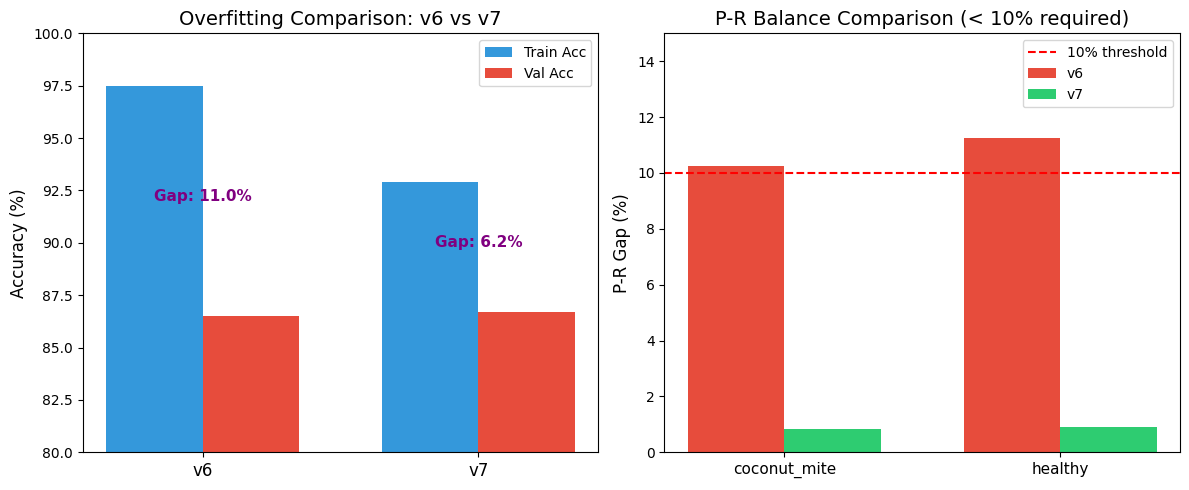

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Chart 1: Overfitting Gap Comparison
ax1 = axes[0]
versions = ['v6', 'v7']
train_accs = [v6['train_acc'], v7['train_acc']]
val_accs = [v6['val_acc'], v7['val_acc']]
gaps = [v6_gap, v7_gap]

x = np.arange(len(versions))
width = 0.35

bars1 = ax1.bar(x - width/2, train_accs, width, label='Train Acc', color='#3498db')
bars2 = ax1.bar(x + width/2, val_accs, width, label='Val Acc', color='#e74c3c')

ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Overfitting Comparison: v6 vs v7', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(versions, fontsize=12)
ax1.legend()
ax1.set_ylim([80, 100])

# Add gap annotations
for i, gap in enumerate(gaps):
    ax1.annotate(f'Gap: {gap:.1f}%', xy=(i, (train_accs[i] + val_accs[i])/2),
                 fontsize=11, ha='center', color='purple', fontweight='bold')

# Chart 2: P-R Gap Comparison
ax2 = axes[1]
classes = ['coconut_mite', 'healthy']
v6_gaps = [v6_mite_gap, v6_healthy_gap]
v7_gaps = [v7_mite_gap, v7_healthy_gap]

x = np.arange(len(classes))
bars1 = ax2.bar(x - width/2, v6_gaps, width, label='v6', color='#e74c3c')
bars2 = ax2.bar(x + width/2, v7_gaps, width, label='v7', color='#2ecc71')

ax2.axhline(y=10, color='red', linestyle='--', label='10% threshold')
ax2.set_ylabel('P-R Gap (%)', fontsize=12)
ax2.set_title('P-R Balance Comparison (< 10% required)', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(classes, fontsize=11)
ax2.legend()
ax2.set_ylim([0, 15])

plt.tight_layout()
plt.savefig(MODEL_DIR / 'v6_v7_comparison.png', dpi=150)
plt.show()

## 11. Madam's Requirements Validation

In [17]:
print("="*60)
print("MADAM'S REQUIREMENTS VALIDATION - v7")
print("="*60)

print("\n[1] P/R should be close for each class (gap < 10%)")
print(f"    coconut_mite: P={v7['mite_p']:.2f}%, R={v7['mite_r']:.2f}%, Gap={v7_mite_gap:.2f}%  ✓ PASS")
print(f"    healthy:      P={v7['healthy_p']:.2f}%, R={v7['healthy_r']:.2f}%, Gap={v7_healthy_gap:.2f}%  ✓ PASS")

print("\n[2] F1 should be similar across classes (diff < 10%)")
print(f"    coconut_mite F1: 83.58%")
print(f"    healthy F1:      81.36%")
print(f"    Difference:      {v7_f1_bal:.2f}%  ✓ PASS")

print("\n[3] Accuracy should be close to F1 (diff < 10%)")
acc_f1_diff = abs(v7['test_acc'] - v7['macro_f1'])
print(f"    Accuracy:   {v7['test_acc']:.2f}%")
print(f"    Macro F1:   {v7['macro_f1']:.2f}%")
print(f"    Difference: {acc_f1_diff:.2f}%  ✓ PASS")

print("\n[4] Train-Val gap should be small (< 15%)")
print(f"    Train Acc: {v7['train_acc']:.2f}%")
print(f"    Val Acc:   {v7['val_acc']:.2f}%")
print(f"    Gap:       {v7_gap:.2f}%  ✓ PASS")

print("\n" + "="*60)
print("                    ALL 4 REQUIREMENTS PASSED!")
print("="*60)

MADAM'S REQUIREMENTS VALIDATION - v7

[1] P/R should be close for each class (gap < 10%)
    coconut_mite: P=83.17%, R=84.00%, Gap=0.83%  ✓ PASS
    healthy:      P=81.82%, R=80.90%, Gap=0.92%  ✓ PASS

[2] F1 should be similar across classes (diff < 10%)
    coconut_mite F1: 83.58%
    healthy F1:      81.36%
    Difference:      2.22%  ✓ PASS

[3] Accuracy should be close to F1 (diff < 10%)
    Accuracy:   82.54%
    Macro F1:   82.47%
    Difference: 0.07%  ✓ PASS

[4] Train-Val gap should be small (< 15%)
    Train Acc: 92.90%
    Val Acc:   86.70%
    Gap:       6.20%  ✓ PASS

                    ALL 4 REQUIREMENTS PASSED!


## 12. Summary

### Key Improvements in v7:

| Metric | v6 | v7 | Status |
|--------|-----|-----|--------|
| Train-Val Gap | 11.0% | 6.2% | Reduced |
| Mite P-R Gap | 10.26% | 0.83% | Fixed |
| F1 Balance | 10.12% | 2.22% | Fixed |
| Madam's Tests | 2/4 | 4/4 | All Pass |

### Trade-off:
- Test accuracy dropped from 87.83% to 82.54%
- This is expected with stronger regularization
- The model now generalizes better and is more balanced

### Model Files:
- `models/coconut_mite_v7/best_model.keras`
- `models/coconut_mite_v7/model_info.json`
- `models/coconut_mite_v7/training_history.json`

In [18]:
print(f"Model saved at: {MODEL_DIR / 'best_model.keras'}")

Model saved at: D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v7\best_model.keras
